In [1]:
import selenium
import requests
from bs4 import BeautifulSoup
import pandas as pd
import tqdm

import re
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

In [9]:
url = "https://reviews.femaledaily.com/products/moisturizer/sun-protection-44/wardah/sun-block-spf-33?cat=&cat_id=0&age_range=&skin_type=&skin_tone=&skin_undertone=&hair_texture=&hair_type=&order=newest&page=1"
headers = {'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64; rv:12.0) Gecko/20100101 Firefox/12.0'}
r = requests.get(url, headers= headers)
soup = BeautifulSoup(r.text, 'html.parser')
prod_detail = soup.find('div',id_="id-product-details")
class_1 = prod_detail.find('div', class_="jsx-2016320139 jsx-2462230538 d-flex review-content-container")
review_col = class_1.find('div', id="review-col")
list_reviews = review_col.find('div', class_="jsx-2016320139 jsx-2462230538 list-reviews") 
review = str(list_reviews.find('p', class_="text-content"))

In [65]:
comment_dict = {}
for i in tqdm.tqdm(range(1, 1000)):
    try:
        url = f"https://reviews.femaledaily.com/products/moisturizer/sun-protection-44/wardah/sun-block-spf-33?cat=&cat_id=0&age_range=&skin_type=&skin_tone=&skin_undertone=&hair_texture=&hair_type=&order=newest&page={i}"
        headers = {'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64; rv:12.0) Gecko/20100101 Firefox/12.0'}
        r = requests.get(url, headers= headers)
        soup = BeautifulSoup(r.text, 'html.parser')
        prod_detail = soup.find('div',id="id-product-details")
        class_1 = prod_detail.find('div', class_="jsx-2016320139 jsx-2462230538 d-flex review-content-container")
        review_col = class_1.find('div', id="review-col")
        list_reviews = review_col.find('div', class_="jsx-2016320139 jsx-2462230538 list-reviews")    

        for review in list_reviews.find_all('div'):
            commentary = str(review.find('p', class_="text-content"))
            long_comment = None
            for i, val in enumerate(commentary.split('span')):
                if i % 2 != 0:
                    if long_comment is None:
                        long_comment = val[1:-2]
                    else:
                        long_comment = long_comment + ' ' + val[1:-2]
                
            if long_comment == None:
                continue
            
            if 'comment' not in comment_dict:
                comment_dict['comment'] = [long_comment]
            else:
                comment_dict['comment'].append(long_comment)
    except AttributeError:
        continue

review_df = (pd.DataFrame(comment_dict)).drop_duplicates().reset_index(drop=True)
review_df


100%|██████████| 999/999 [30:53<00:00,  1.86s/it]


,comment
0,"Sebenernya nothing special sih, cuman karna ba..."
1,Sunscreennya ga lengket ditangan apalagi diwaj...
2,Kalian jangan lupa buat selalu reaply sunscree...
3,"Sunscreen dgn kandungan vit c, vit e dan pro v..."
4,make ini bagus tp on of kalp indor pake ini ka...
...,...
9164,"Untuk harganya, produk ini lumayan sih. Agak s..."
9165,Coba pakai produk ini karena ketularan nyokap ...
9166,Sunscreen ini belum lama aku coba pakai. Sejau...
9167,Kenal produk ini dari teman. Value for money k...


In [66]:
review_df.to_csv("data_review_wardah_sunscreen.csv", index=False)

In [2]:
review_df = pd.read_csv("data_review_wardah_sunscreen.csv")

<h2>Preprocess</h2>

In [3]:
from deep_translator import GoogleTranslator

translated_text = GoogleTranslator(source='en', target='id').translate('aku actually ngerasa sedih')
print(translated_text)


aku sebenarnya ngerasa sedih


In [ ]:
translator = GoogleTranslator(source='en', target='id')
new_text = []
for review in tqdm.tqdm(review_df['comment']):
    new_text.append(translator.translate(str(review)))

review_df['comment'] = new_text

In [5]:
def preprocess_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation and numbers
    text = re.sub(r'[\W\d]+', ' ', text)
    return text

In [6]:
review_df['comment'] = review_df['comment'].apply(preprocess_text)

Devide the data into possitive sentiment and the negative

In [41]:
# Use a pipeline as a high-level helper
from transformers import pipeline

pipe = pipeline("text-classification", model="akahana/indonesia-emotion-roberta", device=0)

c:\Users\user\anaconda3\envs\datascience\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


In [45]:
kalimat = "dia orang yang baik ya bunds."
preds = pipe(kalimat)
preds[0]['label']

'BAHAGIA'

In [ ]:
from transformers import pipeline

pipe = pipeline("text-classification", model="akahana/indonesia-emotion-roberta", device=0)

In [49]:
emotions = []
scores = []
for comment in tqdm.tqdm(review_df['comment']):
    #print(comment)
    try:
        pred = pipe(comment)
        emotions.append(pred[0]['label'])
        scores.append(pred[0]['score'])
    except RuntimeError:
        emotions.append('Null')
        scores.append(0)
        pass

100%|██████████| 9169/9169 [04:28<00:00, 34.09it/s]


In [51]:
review_df['emotion'] = emotions
review_df['score'] = scores
review_df = review_df[review_df['emotion'] != 'Null']
review_df

,comment,emotion,score
0,sebenernya nothing special sih cuman karna bar...,BAHAGIA,0.766092
1,sunscreennya ga lengket ditangan apalagi diwaj...,CINTA,0.930121
2,kalian jangan lupa buat selalu reaply sunscree...,BAHAGIA,0.577896
3,sunscreen dgn kandungan vit c vit e dan pro vi...,BAHAGIA,0.716266
4,make ini bagus tp on of kalp indor pake ini ka...,BAHAGIA,0.712301
...,...,...,...
9164,untuk harganya produk ini lumayan sih agak sed...,SEDIH,0.906026
9165,coba pakai produk ini karena ketularan nyokap ...,SEDIH,0.854096
9166,sunscreen ini belum lama aku coba pakai sejauh...,SEDIH,0.794031
9167,kenal produk ini dari teman value for money ka...,SEDIH,0.636922


<h2>Analysis</h2>

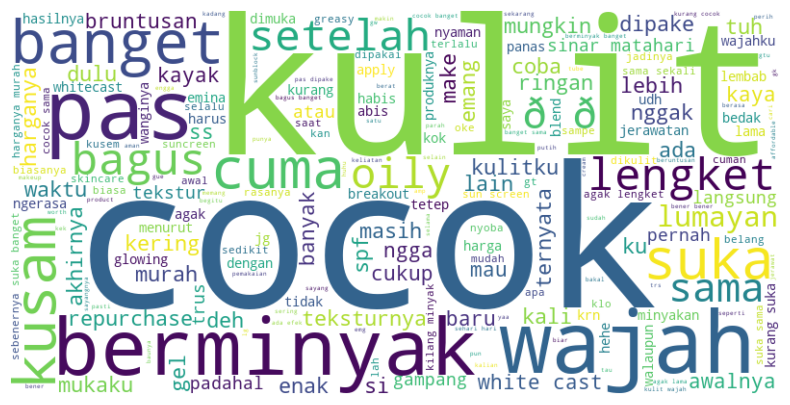

In [53]:
all_text = ' '.join(review_df['comment'])
custom_stopwords = set(STOPWORDS).union({ "yang", "dan", "di", "ke", "dari", "untuk", "ini", "itu", 
                                         "adalah", "juga", "sih", "tapi", "karena", "aku", "lagi", 
                                         "karna", "aja", "ya", "gitu", "kalo", "jadi", "pa", "pakai", 
                                         "kalau", "udah", "jd", "bisa", "menurutku", "ga", "gak", "bikin", "yg",
                                         "soalnya", "produk", 'wardah', "tp", "sunscreen", "malah", "dia", "nya",
                                         "beli", "terus", "apalagi", "pertama", "pake", "muka", "buat", "bgt",
                                         })
wordcloud = WordCloud(width=800, height=400, stopwords=custom_stopwords, background_color='white').generate(all_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

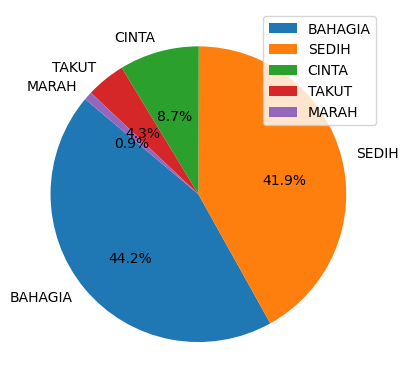

In [87]:
def custom_autopct(pct):
    return ('\n%.1f%%' % pct)
emotions_data = review_df['emotion'].value_counts()
plt.pie(emotions_data, labels=emotions_data.index, autopct=custom_autopct, startangle=140);
plt.legend()
plt.show()


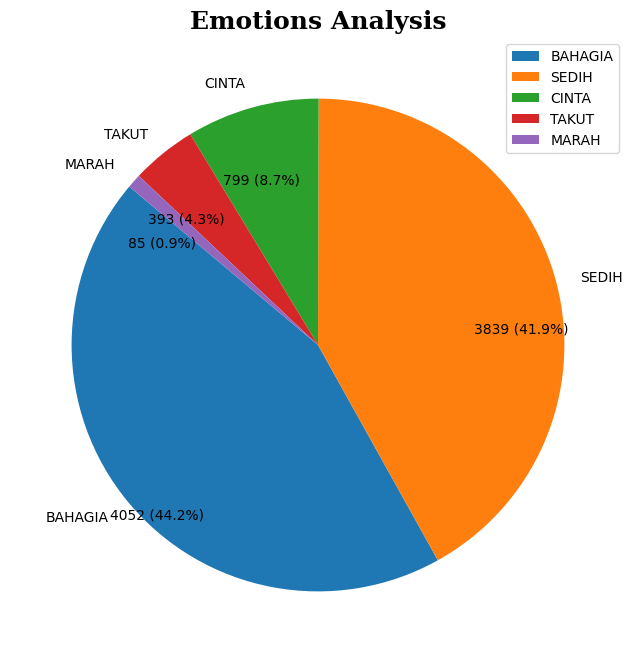

In [90]:
import matplotlib.pyplot as plt

# Function to adjust the position of the autopct text under the label
def custom_autopct(pct, allvalues):
    absolute = int(round(pct/100.*sum(allvalues)))
    return f'{absolute} ({pct:.1f}%)'

# Count the occurrences of each emotion
emotions_data = review_df['emotion'].value_counts()

# Create the pie chart
fig, ax = plt.subplots(figsize=(8, 8))  # Adjust the size of the figure if needed

# The 'explode' parameter can be adjusted if you need to space out the slices
wedges, texts, autotexts = ax.pie(
    emotions_data, 
    labels=emotions_data.index, 
    autopct=lambda pct: custom_autopct(pct, emotions_data), 
    startangle=140,
    pctdistance=0.85,  # Adjust this value to position the autopct under the labels
)

# Adjust the position of the text labels and percentages
for text, autotext in zip(texts, autotexts):
    autotext.set_position((autotext.get_position()[0], autotext.get_position()[1] - 0.15))  # Move the percentage lower
    autotext.set_fontsize(10)  # Adjust font size if needed

plt.legend()
plt.title("Emotions Analysis", fontdict={'fontsize': 18, 'fontweight': 'bold', 'family': 'serif'})

plt.show()


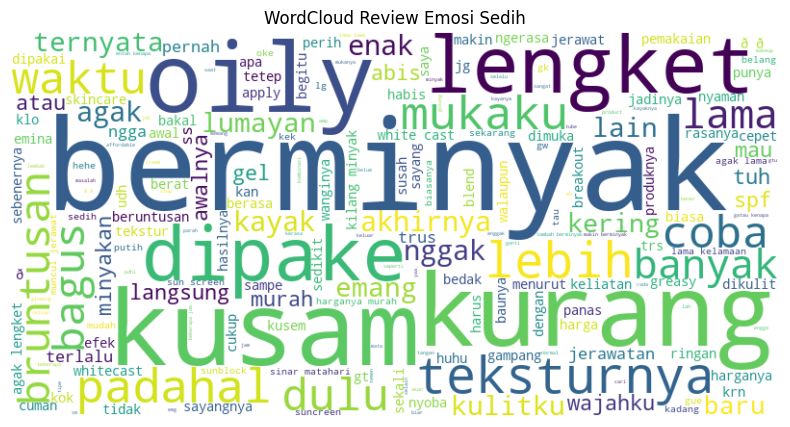

In [75]:
all_text = ' '.join(review_df[review_df['emotion'] == 'SEDIH']['comment'])
custom_stopwords = set(STOPWORDS).union({ "yang", "dan", "di", "ke", "dari", "untuk", "ini", "itu", 
                                         "adalah", "juga", "sih", "tapi", "karena", "aku", "lagi", 
                                         "karna", "aja", "ya", "gitu", "kalo", "jadi", "pa", "pakai", 
                                         "kalau", "udah", "jd", "bisa", "menurutku", "ga", "gak", "bikin", "yg",
                                         "soalnya", "produk", 'wardah', "tp", "sunscreen", "malah", "dia", "nya",
                                         "beli", "terus", "apalagi", "pertama", "pake", "muka", "buat", "bgt",
                                         "kulit", "deh", "ku", "kali", "si", "mungkin", "wajah", "cocok", "repurchase",
                                         "pas", "sama", "ada", "kaya", "suka", "cuma", "banget", "setelah", "make", "masih"
                                         })
wordcloud = WordCloud(width=800, height=400, stopwords=custom_stopwords, background_color='white').generate(all_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud Review Emosi Sedih")
plt.show()

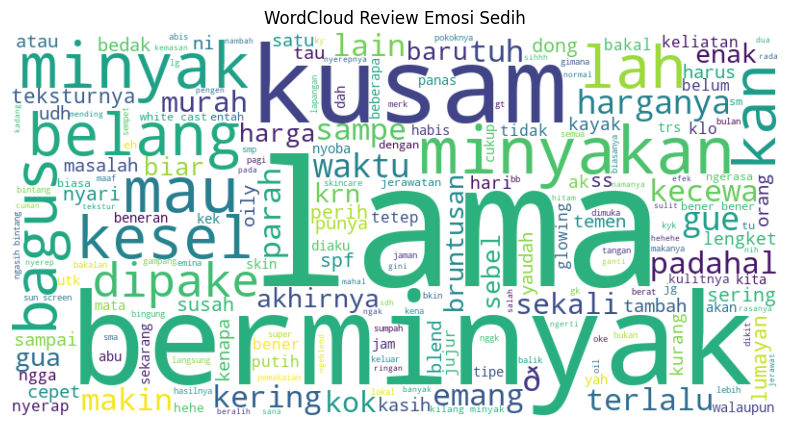

In [80]:
all_text = ' '.join(review_df[review_df['emotion'] == 'MARAH']['comment'])
custom_stopwords = set(STOPWORDS).union({ "yang", "dan", "di", "ke", "dari", "untuk", "ini", "itu", 
                                         "adalah", "juga", "sih", "tapi", "karena", "aku", "lagi", 
                                         "karna", "aja", "ya", "gitu", "kalo", "jadi", "pa", "pakai", 
                                         "kalau", "udah", "jd", "bisa", "menurutku", "ga", "gak", "bikin", "yg",
                                         "soalnya", "produk", 'wardah', "tp", "sunscreen", "malah", "dia", "nya",
                                         "beli", "terus", "apalagi", "pertama", "pake", "muka", "buat", "bgt",
                                         "kulit", "deh", "ku", "kali", "si", "mungkin", "wajah", "cocok", "repurchase",
                                         "pas", "sama", "ada", "kaya", "suka", "cuma", "banget", "setelah", "make", "masih",
                                         "trus", "awal", "gtu", "nggak", "gw", "pernah", "coba", "agak", 'dulu', 'apa'
                                         })
wordcloud = WordCloud(width=800, height=400, stopwords=custom_stopwords, background_color='white').generate(all_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud Review Emosi Sedih")
plt.show()

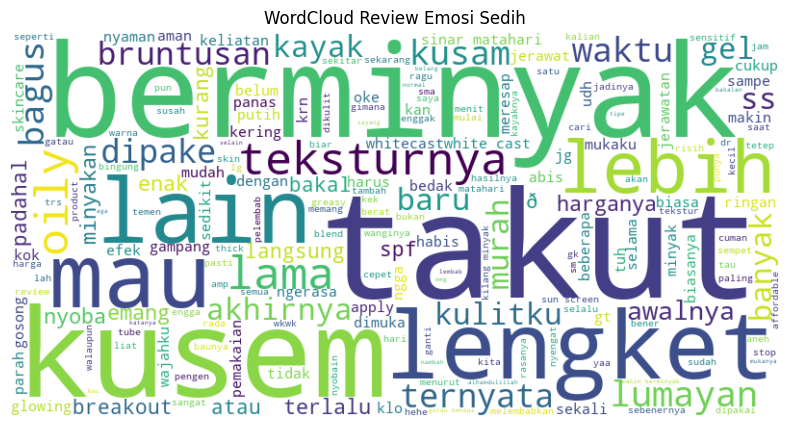

In [81]:
all_text = ' '.join(review_df[review_df['emotion'] == 'TAKUT']['comment'])
custom_stopwords = set(STOPWORDS).union({ "yang", "dan", "di", "ke", "dari", "untuk", "ini", "itu", 
                                         "adalah", "juga", "sih", "tapi", "karena", "aku", "lagi", 
                                         "karna", "aja", "ya", "gitu", "kalo", "jadi", "pa", "pakai", 
                                         "kalau", "udah", "jd", "bisa", "menurutku", "ga", "gak", "bikin", "yg",
                                         "soalnya", "produk", 'wardah', "tp", "sunscreen", "malah", "dia", "nya",
                                         "beli", "terus", "apalagi", "pertama", "pake", "muka", "buat", "bgt",
                                         "kulit", "deh", "ku", "kali", "si", "mungkin", "wajah", "cocok", "repurchase",
                                         "pas", "sama", "ada", "kaya", "suka", "cuma", "banget", "setelah", "make", "masih",
                                         "trus", "awal", "gtu", "nggak", "gw", "pernah", "coba", "agak", 'dulu', 'apa'
                                         })
wordcloud = WordCloud(width=800, height=400, stopwords=custom_stopwords, background_color='white').generate(all_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud Review Emosi Sedih")
plt.show()

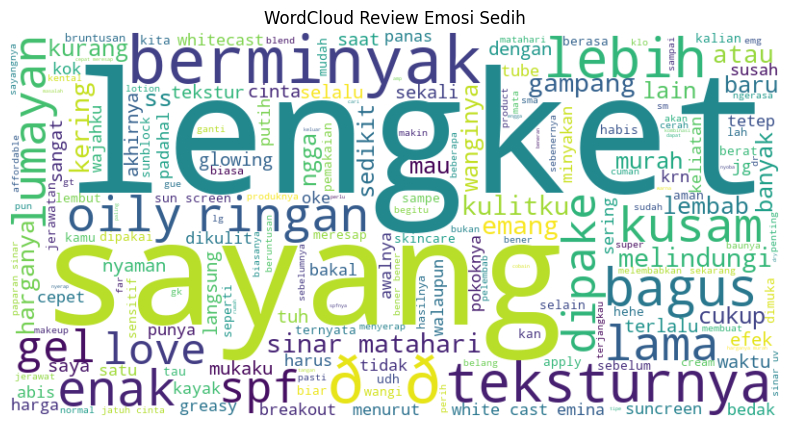

In [82]:
all_text = ' '.join(review_df[review_df['emotion'] == 'CINTA']['comment'])
custom_stopwords = set(STOPWORDS).union({ "yang", "dan", "di", "ke", "dari", "untuk", "ini", "itu", 
                                         "adalah", "juga", "sih", "tapi", "karena", "aku", "lagi", 
                                         "karna", "aja", "ya", "gitu", "kalo", "jadi", "pa", "pakai", 
                                         "kalau", "udah", "jd", "bisa", "menurutku", "ga", "gak", "bikin", "yg",
                                         "soalnya", "produk", 'wardah', "tp", "sunscreen", "malah", "dia", "nya",
                                         "beli", "terus", "apalagi", "pertama", "pake", "muka", "buat", "bgt",
                                         "kulit", "deh", "ku", "kali", "si", "mungkin", "wajah", "cocok", "repurchase",
                                         "pas", "sama", "ada", "kaya", "suka", "cuma", "banget", "setelah", "make", "masih",
                                         "trus", "awal", "gtu", "nggak", "gw", "pernah", "coba", "agak", 'dulu', 'apa'
                                         })
wordcloud = WordCloud(width=800, height=400, stopwords=custom_stopwords, background_color='white').generate(all_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud Review Emosi Sedih")
plt.show()

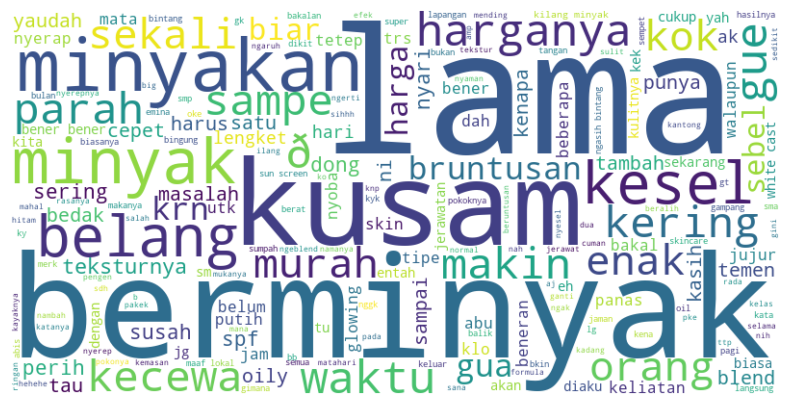

In [127]:
all_text = ' '.join(review_df[review_df['emotion'] == 'MARAH']['comment'])
custom_stopwords = set(STOPWORDS).union({ "yang", "dan", "di", "ke", "dari", "untuk", "ini", "itu", 
                                         "adalah", "juga", "sih", "tapi", "karena", "aku", "lagi", 
                                         "karna", "aja", "ya", "gitu", "kalo", "jadi", "pa", "pakai", 
                                         "kalau", "udah", "jd", "bisa", "menurutku", "ga", "gak", "bikin", "yg",
                                         "soalnya", "produk", 'wardah', "tp", "sunscreen", "malah", "dia", "nya",
                                         "beli", "terus", "apalagi", "pertama", "pake", "muka", "buat", "bgt",
                                         "kulit", "deh", "ku", "kali", "si", "mungkin", "wajah", "cocok", "repurchase",
                                         "pas", "sama", "ada", "kaya", "suka", "cuma", "banget", "setelah", "make", "masih",
                                         "trus", "awal", "gtu", "nggak", "gw", "pernah", "coba", "agak", 'dulu', 'apa', 'hehe', 'bagus',
                                         'ternyata', 'tuh', 'emang', 'ss', 'awalnya', 'dipake', 'baru', 'saya', 'mau', 'mukaku', 'habis', 'ngerasa',
                                         'ngga', 'lain', 'menurut', 'menurutku', 'pemakaian', 'dimuka', 'lebih', 'atau', 'kayak', 'padahal', 'lumayan',
                                         'akhirnya', 'kulitku', 'terlalu', 'banyak', 'tidak', 'kurang', 'udh', 'lah', 'kan'
                                         
                                         })
wordcloud = WordCloud(width=800, height=400, stopwords=custom_stopwords, background_color='white').generate(all_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
#plt.title("WordCloud Review Emosi Sedih")
plt.show()

By this wordcloud, we can understand that whatever people think on this product, the problem they have to face is almost the same, it is related to the texture (e.g oily, lengket) and what people get the product is because of the price and the spf it had

In [84]:
review_df.rename(columns={'comment':'review'})

,review,emotion,score
0,sebenernya nothing special sih cuman karna bar...,BAHAGIA,0.766092
1,sunscreennya ga lengket ditangan apalagi diwaj...,CINTA,0.930121
2,kalian jangan lupa buat selalu reaply sunscree...,BAHAGIA,0.577896
3,sunscreen dgn kandungan vit c vit e dan pro vi...,BAHAGIA,0.716266
4,make ini bagus tp on of kalp indor pake ini ka...,BAHAGIA,0.712301
...,...,...,...
9164,untuk harganya produk ini lumayan sih agak sed...,SEDIH,0.906026
9165,coba pakai produk ini karena ketularan nyokap ...,SEDIH,0.854096
9166,sunscreen ini belum lama aku coba pakai sejauh...,SEDIH,0.794031
9167,kenal produk ini dari teman value for money ka...,SEDIH,0.636922


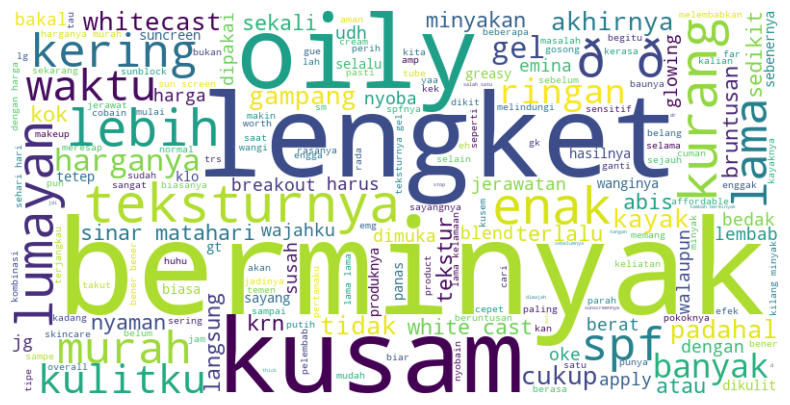

In [102]:
all_text = ' '.join(review_df['comment'])
custom_stopwords = set(STOPWORDS).union({ "yang", "dan", "di", "ke", "dari", "untuk", "ini", "itu", 
                                         "adalah", "juga", "sih", "tapi", "karena", "aku", "lagi", 
                                         "karna", "aja", "ya", "gitu", "kalo", "jadi", "pa", "pakai", 
                                         "kalau", "udah", "jd", "bisa", "menurutku", "ga", "gak", "bikin", "yg",
                                         "soalnya", "produk", 'wardah', "tp", "sunscreen", "malah", "dia", "nya",
                                         "beli", "terus", "apalagi", "pertama", "pake", "muka", "buat", "bgt",
                                         "kulit", "deh", "ku", "kali", "si", "mungkin", "wajah", "cocok", "repurchase",
                                         "pas", "sama", "ada", "kaya", "suka", "cuma", "banget", "setelah", "make", "masih",
                                         "trus", "awal", "gtu", "nggak", "gw", "pernah", "coba", "agak", 'dulu', 'apa', 'hehe', 'bagus',
                                         'ternyata', 'tuh', 'emang', 'ss', 'awalnya', 'dipake', 'baru', 'saya', 'mau', 'mukaku', 'habis', 'ngerasa',
                                         'ngga', 'lain', 'menurut', 'menurutku', 'pemakaian'
                                         })
wordcloud = WordCloud(width=800, height=400, stopwords=custom_stopwords, background_color='white').generate(all_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()